<a href="https://colab.research.google.com/github/BadGe-D/DATN/blob/main/Copy_of_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from numpy import array

In [ ]:
import pandas as pd

# Try reading the file with a different encoding, such as 'latin1'
try:
    df = pd.read_csv("/content/drive/MyDrive/DATN/dataset/caption.csv", encoding='latin1')
except UnicodeDecodeError:
    # If 'latin1' doesn't work, try 'utf-16'
    try:
        df = pd.read_csv("/content/drive/MyDrive/DATN/dataset/caption.csv", encoding='utf-16')
    except UnicodeDecodeError:
        # If neither 'latin1' nor 'utf-16' work, try 'ISO-8859-1'
        df = pd.read_csv("/content/drive/MyDrive/DATN/dataset/caption.csv", encoding='ISO-8859-1')

df

,image,caption,caption(English)
0,1.jpg,"Phía bên ph?i có v?t c?n, ?i ch?ch v? bên trái...","There is an obstacle on the right, move slight..."
1,1.jpg,Có v?t c?n ? phía bên ph?i,There is an obstacle on the right side
2,1.jpg,"Bên ph?i có v?t c?n, ?i sang bên trái 1 tí","There is an obstacle on the right, move a litt..."
3,1.jpg,"Bên trái t??ng ??i v?ng, bên ph?i có v?t c?n","The left side is relatively clear, the right s..."
4,1.jpg,V?t c?n ? phía ph?i,Obstacle on the right side
...,...,...,...
576,122.jpg,NaN,"There are many consecutive obstacles ahead, bu..."
577,122.jpg,NaN,"Ahead, a series of manageable obstacles are li..."
578,122.jpg,NaN,There are multiple successive obstacles in fro...
579,122.jpg,NaN,Numerous obstacles are positioned consecutivel...


In [ ]:
train, val = np.split(df.sample( frac=1,random_state=42), [int(.8*len(df)),])
print(len(df), train.shape, val.shape)

581 (464, 3) (117, 3)


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
image_path = '/content/drive/MyDrive/DATN/dataset/'

In [ ]:
import re
def caption_preprocessing(text, remove_digits=True):
  # remove punctuation
  pattern=r'[^a-zA-z0-9\s]'
  text=re.sub(pattern,'',text)

  # tokenize
  text=text.split()
  # convert to lower case
  text = [word.lower() for word in text]

  # remove tokens with numbers in them
  text = [word for word in text if word.isalpha()]
  # concat string
  text =  ' '.join(text)

  # insert 'startseq', 'endseq'
  text = 'startseq ' + text + ' endseq'
  return text


In [ ]:
df['caption(English)'] = df['caption(English)'].apply(caption_preprocessing)

In [ ]:
word_counts = {}  # a dict : { word : number of appearances}
max_length = 0
for text in df['caption(English)']:
  words = text.split()
  max_length = len(words) if (max_length < len(words)) else max_length
  for w in words:
    try:
      word_counts[w] +=1
    except:
        word_counts[w] = 1
print(len(word_counts))
print(max_length)

# Chỉ lấy các từ xuất hiện trên 1 lần
word_count_threshold = 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('After preprocessed %d -> %d' % (len(word_counts), len(vocab)))

321
42
After preprocessed 321 -> 321


In [ ]:
i2w = {}
w2i = {}

id = 1
for w in vocab:
    w2i[w] = id
    i2w[id] = w
    id += 1

print(len(i2w), len(w2i))
print(i2w[300])

321 321
keeps


In [ ]:
! wget https://nlp.stanford.edu/data/glove.6B.zip
! mkdir glove
! unzip glove.6B.zip -d glove

--2025-04-03 13:36:50--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-03 13:36:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip         64%[===========>        ] 531.96M  5.01MB/s    eta 59s    ^C
mkdir: cannot create directory ‘glove’: File exists
Archive:  glove.6B.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one dis

In [ ]:
glove_dir = '/content/glove/'
embeddings_index = {} # empty dictionary
file = open(glove_dir + 'glove.6B.200d.txt', encoding="utf-8")

for line in file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
file.close()
print('Found %s word vectors.' % len(embeddings_index))

FileNotFoundError: [Errno 2] No such file or directory: '/content/glove/glove.6B.200d.txt'

In [ ]:
embeddings_index['left'].shape

In [ ]:
embedding_dim = 200
vocab_size = len(vocab) + 1

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in w2i.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)


In [ ]:
from pickle import dump, load

In [ ]:
with open("/content/drive/MyDrive/DATN/Embedding_matrix.pkl", "wb") as file:
    dump(embedding_matrix, file)

In [ ]:
embedding_matrix = load(open("/content/drive/MyDrive/DATN/Embedding_matrix.pkl", "rb"))
embedding_matrix.shape

(322, 200)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from keras.utils import plot_model # Import plot_model from tensorflow.keras.utils
# model needs to be defined before being used
model = InceptionV3()

# Tạo model mới, bỏ layer cuối từ inception v3
model_new = Model(model.input, model.layers[-2].output)
model_new.input_shape


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


(None, 299, 299, 3)

In [ ]:
images = {}
captions = {}

start = time()
for i in range(len(df)):
  images[df['image'][i]] = np.array(Image.open(image_path + df['image'][i])) # Make sure 'image_path' is correctly defined
  try:
    captions[df['image'][i]].append(df['caption(English)'][i])
  except:
    captions[df['image'][i]] = [df['caption(English)'][i]]

print(len(images), len(captions))
print('Time: ',time() - start)

116 116
Time:  102.31255745887756


In [ ]:
with open("/content/drive/MyDrive/DATN/encoded.pkl", "wb") as file:
    dump(captions, file)

In [ ]:
captions = load(open("/content/drive/MyDrive/DATN/encoded.pkl", "rb"))
len(captions)

116

In [ ]:
images[df['image'][0]].shape

(426, 640, 3)

In [ ]:
tmp = np.array([[0,2,1],[3,5,6]])
tmp = np.expand_dims(tmp, axis=0)
tmp

array([[[0, 2, 1],
        [3, 5, 6]]])

In [ ]:
from keras.applications.inception_v3 import preprocess_input
# Image embedding thành vector (2048, )
def encode(image):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = np.resize(image, (299, 299, 3 ))
    # Add one more dimension
    img = np.expand_dims(img, axis=0)
    # preprocess the images using preprocess_input() from inception module
    img = preprocess_input(img)

    fea_vec = model_new.predict(img) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec


In [ ]:
# Gọi hàm encode với các ảnh trong traning set
start = time()
encoding_image = {}
for id, img in images.items():
    encoding_image[id] = encode(img)
print("Time taken in seconds =", time()-start)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━

In [ ]:
encoding_image['122.jpg'].shape

(2048,)

In [ ]:
train_features = encoding_image

In [ ]:
from pickle import dump, load
with open("/content/drive/MyDrive/DATN/encoded_train_images.pkl", "wb") as file:
    dump(encoding_image, file)

In [ ]:
train_features = load(open("/content/drive/MyDrive/DATN/encoded_train_images.pkl", "rb"))
len(train_features)

116

In [ ]:
model="a"

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


def data_generator(captions, images, w2i, max_length, batch_size):
  X_image, X_cap, y = [], [], []
  n = 0
  while 1:
    for id, caps in captions.items():
      n += 1
      image = images[id]
      for cap in caps:
        # encode the sequence
        seq = [w2i[word] for word in cap.split(' ') if word in w2i]

        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]

          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length,padding='post')[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store
          X_image.append(image)
          X_cap.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        # Yielding as a tuple instead of a list
        yield (np.array(X_image), np.array(X_cap)), np.array(y)
        X_image, X_cap, y = [], [], []
        n = 0
  # # Define output_signature correctly using tf.TensorSpec
  # output_signature = (
  #     (tf.TensorSpec(shape=(batch_size, 2048), dtype=tf.float32),  # Image shape and type
  #      tf.TensorSpec(shape=(batch_size, max_length), dtype=tf.int32)),  # Caption shape and type
  #     tf.TensorSpec(shape=(batch_size, vocab_size), dtype=tf.float32)  # Output shape and type
  # )

  # # Create dataset from generator with output_signature
  # dataset = tf.data.Dataset.from_generator(
  #     lambda: data_generator(captions, images, w2i, max_length, batch_size),
  #     output_signature=output_signature
  # )

  # return dataset # Return the dataset


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import Input
from tensorflow.keras import optimizers

In [ ]:
# Tạo model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

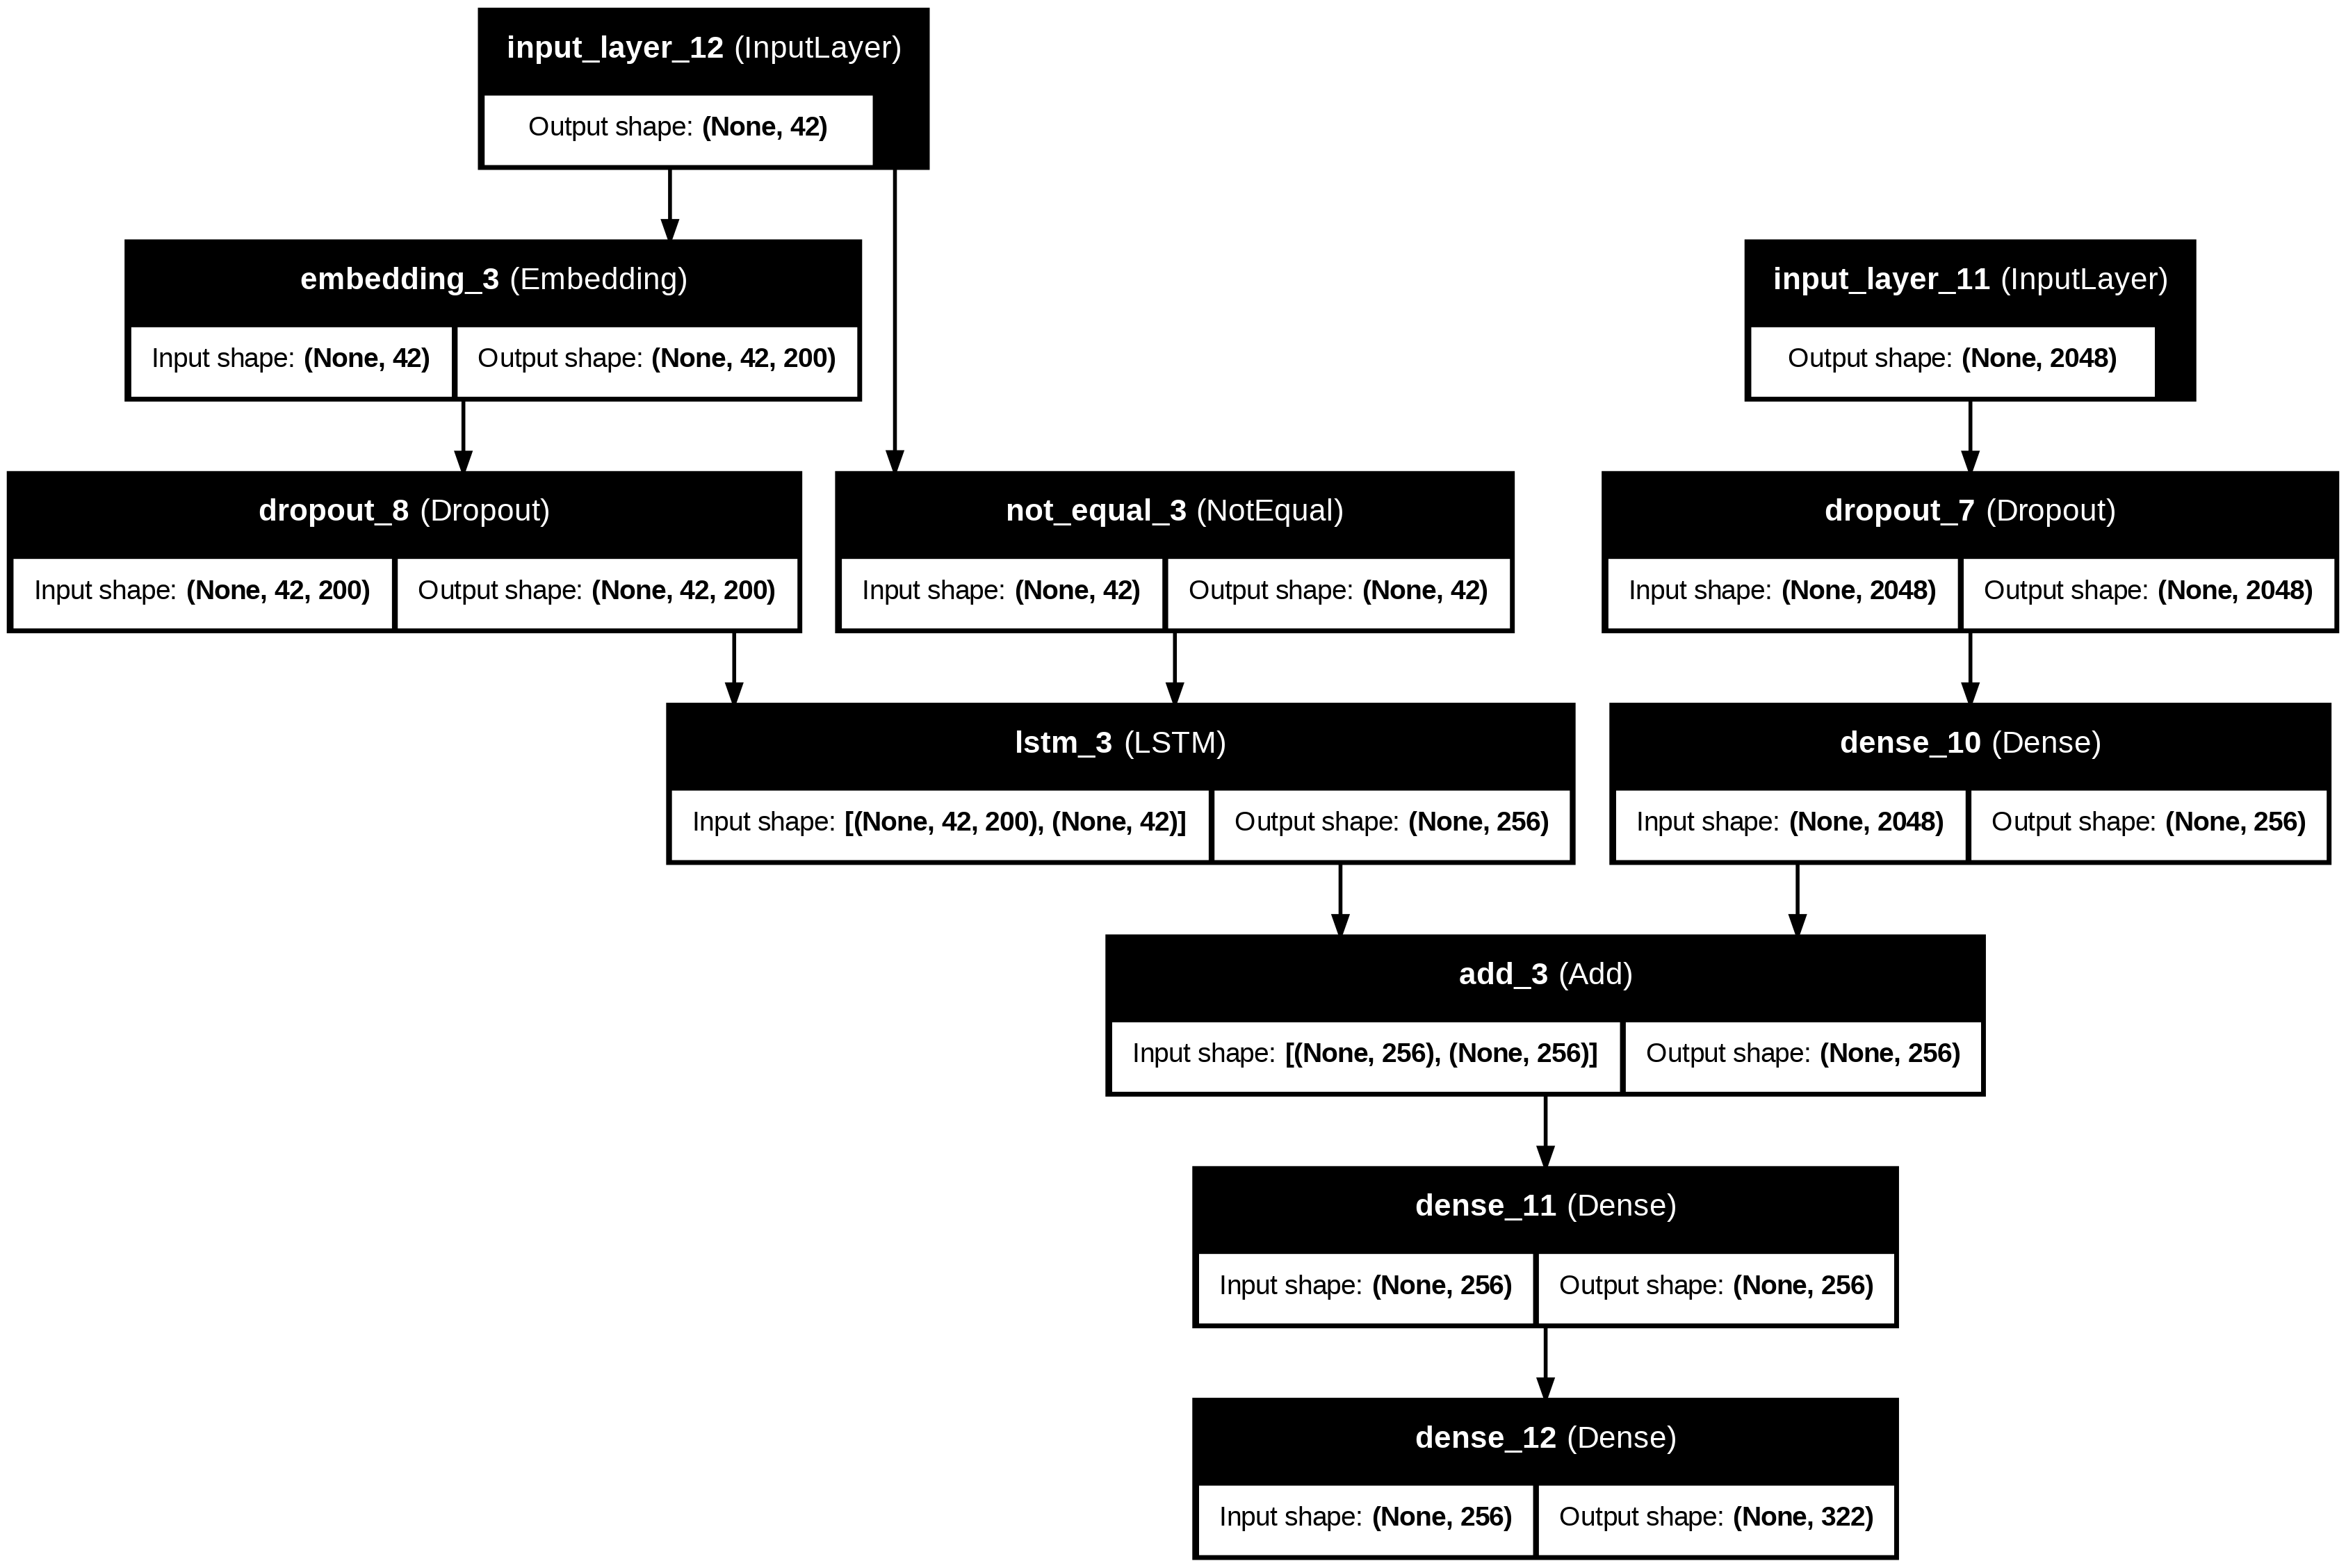

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 42)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 42, 200)        │         64,400 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 2048)           │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 42, 200)        │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 42)             │              0 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 256)            │        524,544 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 256)            │        467,968 │ dropout_8[0][0],       │
│                           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 256)            │              0 │ dense_10[0][0],        │
│                           │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 256)            │         65,792 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 322)            │         82,754 │ dense_11[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,205,458 (4.60 MB)

 Trainable params: 1,205,458 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.layers[2]

<Embedding name=embedding_3, built=True>

In [ ]:
# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.optimizer.lr = 0.0001
epochs = 10
batch_size = 16
steps = len(train_features)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/DATN/cp.weights.h5"  # Change the file extension to .weights.h5

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_best_only=False, save_weights_only=True, verbose=1)

In [ ]:
print(type(model))

<class 'keras.src.models.functional.Functional'>


In [ ]:
generator = data_generator(captions=captions, images=train_features, w2i=w2i, max_length=max_length, batch_size=batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[cp_callback])

Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.8690
Epoch 1: saving model to /content/drive/MyDrive/DATN/cp.weights.h5
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 3.8629
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.9063
Epoch 2: saving model to /content/drive/MyDrive/DATN/cp.weights.h5
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 1.9044
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.2216
Epoch 3: saving model to /content/drive/MyDrive/DATN/cp.weights.h5
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 1.2204
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.8083
Epoch 4: saving model to /content/drive/MyDrive/DATN/cp.weights.h5
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 0.8076
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.5543
Epoch 5: saving model to /content/drive/MyDrive/DATN/cp.weights.h5
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.5539
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━

In [ ]:
model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[cp_callback])

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1913
Epoch 1: saving model to /content/drive/MyDrive/DATN/cp.weights.h5
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.1913


In [ ]:
model.save_weights('/content/drive/MyDrive/DATN/model.weights.h5')

In [ ]:
model.save('/content/drive/MyDrive/DATN/model.keras')

In [ ]:
for layer in model.layers:
    print(layer.name)

input_layer_12
input_layer_11
embedding_3
dropout_7
dropout_8
dense_10
lstm_3
add_3
dense_11
dense_12


In [ ]:
# Print the model configuration
model_config = model.get_config()
print(model_config)

# Iterate through the layers and print details
for layer in model.layers:
    print("Layer name:", layer.name)
    print("Layer type:", type(layer))
    print("Layer configuration:", layer.get_config())
    print("\n")

{'name': 'functional_6', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 42), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_12'}, 'registered_name': None, 'name': 'input_layer_12', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 2048), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_11'}, 'registered_name': None, 'name': 'input_layer_11', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'embedding_3', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'input_dim': 322, 'output_dim': 200, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'seed': None, 'minval': -0.05, 'maxval': 0.05}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regula

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
# Đảm bảo rằng lớp NotEqual đã được định nghĩa và đăng ký trước đó
model = tf.keras.models.load_model('/content/drive/MyDrive/DATN/model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model_new.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 149, 149, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 149, 149, 32)   │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 149, 149, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 147, 147, 32)   │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 147, 147, 32)   │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 147, 147, 64)   │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 147, 147, 64)   │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 147, 147, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 73, 73, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 73, 73, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 73, 73, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [w2i[w] for w in in_text.split() if w in w2i]
        sequence = pad_sequences([sequence], maxlen=max_length,padding="post")
        # Use the trained model (`model`) for prediction instead of `model_new`
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = i2w[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

251    startseq on the right there is an obstacle the...
252    startseq must be blocked in front of the small...
253    startseq obstacle on the right narrow path ahe...
254    startseq on the right there is an obstacle in ...
255    startseq must be blocked in front the road nar...
Name: caption(English), dtype: object


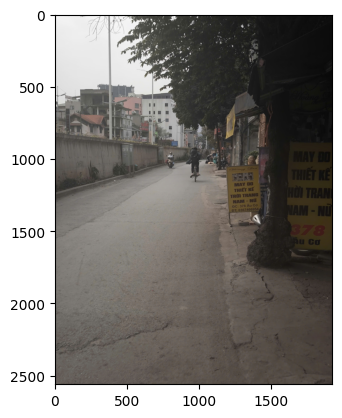

must be blocked in front the road narrows on the left there is a moving vehicle


In [ ]:
pic = list(train_features.keys())[50]
image = train_features[pic].reshape((1,2048))
img = Image.open(image_path + pic)
print(df['caption(English)'][df['image'] == pic])
plt.imshow(img)
plt.show()
predict = greedySearch(image)
print(predict)

In [ ]:
pic

'52.jpg'

In [ ]:
# @title TESTING
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
model = tf.keras.models.load_model('/content/drive/MyDrive/DATN/model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def TestingGreedySearch(photo):
    in_text = 'startseq'
    for i in range(42):
        sequence = [w2i[w] for w in in_text.split() if w in w2i]
        sequence = pad_sequences([sequence], maxlen=42,padding="post")
        # Use the trained model (`model`) for prediction instead of `model_new`
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = i2w[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Saving test.jpg to test (7).jpg
User uploaded file "test (7).jpg" with length 2171999 bytes


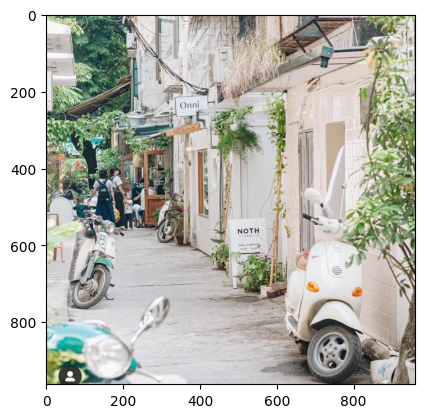

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
the road ahead is crowded with obstacles on both sides


In [ ]:
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image

uploaded = files.upload()
predict=""
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Assuming the uploaded file is the image
  image_path = fn  # Use the uploaded filename

  try:
      img = Image.open(image_path)
      plt.imshow(img)
      plt.show()
      # Assuming 'encode' and 'greedySearch' functions are defined as in your previous code
      image = encode(np.array(img))  # Encode the image
      image = image.reshape((1, 2048))
      predict = TestingGreedySearch(image)
      print(predict)

  except Exception as e:
      print(f"Error processing image: {e}")


In [ ]:
!pip install gtts
!pip install googletrans

In [ ]:
from gtts import gTTS
from IPython.display import Audio
import googletrans
import asyncio
import nest_asyncio

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

async def translate_text(text, target_language='vi'):
    translator = googletrans.Translator()
    # Use await to get the result of the coroutine
    translated = await translator.translate(text, dest=target_language)
    return translated.text

def text_to_speech_translation(text, target_language='vi', filename="speech.mp3"):
    # Get the event loop using nest_asyncio
    loop = asyncio.get_event_loop()
    # Run the translate_text coroutine in the event loop
    translated_text = loop.run_until_complete(translate_text(text, target_language))
    # Create and save the audio file
    tts = gTTS(text=translated_text, lang=target_language)
    tts.save(filename)
    return filename

# Example usage with the 'predict' variable:
print(predict)
audio_file = text_to_speech_translation(predict)
Audio(audio_file, autoplay=True)

<function translate_text at 0x7a18083a8ea0>
